In [1]:
# import packages
import sys
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# load the dataset
df = pd.read_csv("../../DataSet/mnist_train.csv")

In [3]:
# input and output features
X = df.iloc[:,1:].to_numpy() / 255.0 # Normalizing between 0 to 1
Y = df.iloc[:,0].to_numpy()

In [4]:
# split into train and test data
Xtrain, Xtest, Ytrain, Ytest = X[:-1000], X[-1000:], Y[:-1000], Y[-1000:]

In [5]:
# Shuffle the training data
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

In [6]:
# Show PIC func
def showPIC(x,y):
    plt.figure(figsize=(2,2))
    plt.title("Digit: "+str(y))
    plt.imshow(x.reshape(28,28))
    plt.show()

<IPython.core.display.Javascript object>


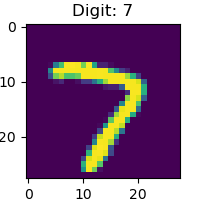

In [7]:
# Testing a PIC
pic_id = 1
showPIC(Xtrain[pic_id], Ytrain[pic_id])

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

In [10]:
def relu(z):
    return z*(z>0)

In [11]:
def softmax(z):
    return np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)

In [12]:
def oneHotEncode(y):
    T = np.zeros((y.shape[0], np.unique(y).shape[0]))
    
    for i,val in enumerate(y):
        T[i,val] = 1
        
    return T

In [13]:
def nonlinearDr(z,activation):
    if activation=="sigmoid":
        return z*(1-z)
    if activation=="tanh":
        return (1-z**2)
    if activation=="relu":
        return (z>0)

In [14]:
def cost(t,y):
    return -np.sum(t*np.log(y))

In [43]:
def forward(X,T,hidden,activation,W,B,A,Vw,Vb,cache_W,cache_B,i,seed):
    D = X.shape[1]
    K = T.shape[1]
    L = len(hidden)
    
    for l in range(L+1):
        if l==0:
            if i==0:
                W[l] = np.random.randn(D,hidden[l])
                B[l] = np.random.randn(hidden[l])
                Vw[l] = 0
                Vb[l] = 0
                cache_W[l] = 0
                cache_B[l] = 0
            A[l] = activation(np.dot(X,W[l])+B[l])
            
        elif l==L:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],K)
                B[l] = np.random.randn(K)
                Vw[l] = 0
                Vb[l] = 0
                cache_W[l] = 0
                cache_B[l] = 0
            A[l] = softmax(np.dot(A[l-1],W[l])+B[l])
            Y = A[l]
            
        else:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],hidden[l])
                B[l] = np.random.randn(hidden[l])
                Vw[l] = 0
                Vb[l] = 0
                cache_W[l] = 0
                cache_B[l] = 0
            A[l] = activation(np.dot(A[l-1],W[l])+B[l])
    
    return W,B,A,Vw,Vb,cache_W,cache_B,Y

In [65]:
def backprop(X,T,Y,hidden,activation,lr,momentum,Nesterov,AdaGrad,RMSProp,decay,cache_W,cache_B,W,B,A,Vw,Vb):
    L = len(hidden)
    Err,Grad = {},{}
    
    for l in range(L,-1,-1):
        if l==L:
            Err[l] = T-Y
            Grad[l] = Err[l]
            
        else:
            Err[l] = np.dot(Grad[l+1],W[l+1].T)
            Grad[l] = Err[l]*nonlinearDr(A[l],activation.__name__)
            
    for l in range(L+1):
        if AdaGrad:
            if l==0:
                gradW = np.dot(X.T,Grad[l])
                gradB = Grad[l].sum(axis=0)
                cache_W[l] += gradW ** 2
                cache_B[l] += gradB ** 2
                W[l] += lr * gradW / (np.sqrt(cache_W[l]) + 1e-8)
                B[l] += lr * gradB / (np.sqrt(cache_B[l]) + 1e-8)
            else:
                gradW = np.dot(A[l-1].T, Grad[l])
                gradB = Grad[l].sum(axis=0)
                cache_W[l] += gradW ** 2
                cache_B[l] += gradB ** 2
                W[l] += lr * gradW / (np.sqrt(cache_W[l]) + 1e-8)
                B[l] += lr * gradB / (np.sqrt(cache_B[l]) + 1e-8)
                
        elif RMSProp:
            if l==0:
                gradW = np.dot(X.T,Grad[l])
                gradB = Grad[l].sum(axis=0)
                cache_W[l] = cache_W[l] * decay + (1 - decay) * gradW ** 2
                cache_B[l] = cache_B[l] * decay + (1 - decay) * gradB ** 2
                W[l] += lr * gradW / (np.sqrt(cache_W[l]) + 1e-8)
                B[l] += lr * gradB / (np.sqrt(cache_B[l]) + 1e-8)
            else:
                gradW = np.dot(A[l-1].T, Grad[l])
                gradB = Grad[l].sum(axis=0)
                cache_W[l] = cache_W[l] * decay + (1 - decay) * gradW ** 2
                cache_B[l] = cache_B[l] * decay + (1 - decay) * gradB ** 2
                W[l] += lr * gradW / (np.sqrt(cache_W[l]) + 1e-8)
                B[l] += lr * gradB / (np.sqrt(cache_B[l]) + 1e-8)
                
        elif Nesterov:
            if l==0:
                Vw[l] = Vw[l] * momentum + lr * np.dot(X.T,Grad[l])
                Vb[l] = Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                W[l] += Vw[l] * momentum + lr * np.dot(X.T,Grad[l])
                B[l] += Vb[l] * momentum + lr * Grad[l].sum(axis=0)
            else:
                Vw[l] = Vw[l] * momentum + lr * np.dot(A[l-1].T, Grad[l])
                Vb[l] = Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                W[l] += Vw[l] * momentum + lr * np.dot(A[l-1].T, Grad[l])
                B[l] += Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                
        else:
            if l==0:
                Vw[l] = Vw[l] * momentum + lr * np.dot(X.T,Grad[l])
                Vb[l] = Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                W[l] += Vw[l]
                B[l] += Vb[l]
            else:
                Vw[l] = Vw[l] * momentum + lr * np.dot(A[l-1].T, Grad[l])
                Vb[l] = Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                W[l] += Vw[l]
                B[l] += Vb[l]
            
    return W,B,Vw,Vb,cache_W,cache_B

In [53]:
def train(X,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,momentum,Nesterov,AdaGrad,RMSProp,decay,batch_size,seed):
    N = X.shape[0]
    n_batches = N // batch_size
    
    T = oneHotEncode(Ytrain)
    Ttest = oneHotEncode(Ytest)
    W,B,A,Vw,Vb,cache_W,cache_B = {},{},{},{},{},{},{}
    Ctrain, Ctest = [],[]
    
    for i in range(iterations):
        for j in range(n_batches):
            start = batch_size*j
            end = batch_size*(j+1)
            
            W,B,A,Vw,Vb,cache_W,cache_B,Y = forward(X[start:end],T[start:end],hidden,activation,W,B,A,Vw,Vb,cache_W,cache_B,i,seed)
            W,B,Vw,Vb,cache_W,cache_B = backprop(X[start:end],T[start:end],Y,hidden,activation,lr,momentum,Nesterov,AdaGrad,RMSProp,decay,cache_W,cache_B,W,B,A,Vw,Vb)
            _,_,_,_,_,_,_,Y_test = forward(Xtest,Ttest,hidden,activation,W,B,A,Vw,Vb,cache_W,cache_B,i,seed)

            trCost = cost(T[start:end],Y)
            teCost = cost(Ttest,Y_test)

            Ctrain.append(trCost)
            Ctest.append(teCost)

            sys.stdout.write("\rIterations: {} | Batch: {} | Training Cost: {} | Test Cost: {}".format(
                i+1, j+1, trCost, teCost))
        
    return Ctrain, Ctest, W, B, Vw, Vb, Y, Y_test

In [24]:
# Full Gradient Descent - No Momentum
hidden = [100]
activation = sigmoid
iterations = 100
lr = 0.00001
momentum = 0
Nesterov = False
AdaGrad = False
RMSProp = False
decay = 0
batch_size = Xtrain.shape[0] # All the samples
seed = 1

Ctrain_full, Ctest_full, W, B, Vw, Vb, Y, Y_test = train(Xtrain,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,
                                                         momentum,
                                                         Nesterov,
                                                         AdaGrad,
                                                         RMSProp,
                                                         decay,
                                                         batch_size,
                                                         seed)

Iterations: 100 | Batch: 1 | Training Cost: 56394.12699401771 | Test Cost: 842.51865672219386

In [25]:
# Mini Batch Gradient Descent - No Momentum
hidden = [100]
activation = sigmoid
iterations = 100
lr = 0.00001
momentum = 0
Nesterov = False
AdaGrad = False
RMSProp = False
decay = 0
batch_size = 10000 # Batch Sample size
seed = 1

Ctrain_batch, Ctest_batch, W, B, Vw, Vb, Y, Y_test = train(Xtrain,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,
                                                         momentum,
                                                         Nesterov,
                                                         AdaGrad,
                                                         RMSProp,
                                                         decay,
                                                         batch_size,
                                                         seed)

Iterations: 100 | Batch: 5 | Training Cost: 10143.426493623807 | Test Cost: 741.2350975418673

In [26]:
# Mini Batch Gradient Descent with Momentum
hidden = [100]
activation = sigmoid
iterations = 100
lr = 0.00001
momentum = 0.95
Nesterov = False
AdaGrad = False
RMSProp = False
decay = 0
batch_size = 10000 # Batch Sample size
seed = 1

Ctrain_batch_m, Ctest_batch_m, W, B, Vw, Vb, Y, Y_test = train(Xtrain,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,
                                                         momentum,
                                                         Nesterov,
                                                         AdaGrad,
                                                         RMSProp,
                                                         decay,
                                                         batch_size,
                                                         seed)

Iterations: 100 | Batch: 5 | Training Cost: 3047.2672881922977 | Test Cost: 273.18424605649965

In [27]:
# Mini Batch Gradient Descent with Nesterov Momentum
hidden = [100]
activation = sigmoid
iterations = 100
lr = 0.00001
momentum = 0.95
Nesterov = True # Turned this ON
AdaGrad = False # Turned this OFF
RMSProp = False # Turned this OFF
decay = 0
batch_size = 10000 # Batch Sample size
seed = 1

Ctrain_batch_nm, Ctest_batch_nm, W, B, Vw, Vb, Y, Y_test = train(Xtrain,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,
                                                         momentum,
                                                         Nesterov,
                                                         AdaGrad,
                                                         RMSProp,
                                                         decay,
                                                         batch_size,
                                                         seed)

Iterations: 100 | Batch: 5 | Training Cost: 3017.0368824572192 | Test Cost: 260.49787674494646

In [75]:
# Mini Batch Gradient Descent with AdaGrad
hidden = [100]
activation = sigmoid
iterations = 100
lr = 0.1 # Increased the Learning Rate from 0.0001
momentum = 0.95
Nesterov = False # Turned this OFF
AdaGrad = True # Turned this ON
RMSProp = False # Turned this OFF
decay = 0
batch_size = 10000 # Batch Sample size
seed = 1

Ctrain_batch_Ada, Ctest_batch_Ada, W, B, Vw, Vb, Y, Y_test = train(Xtrain,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,
                                                         momentum,
                                                         Nesterov,
                                                         AdaGrad,
                                                         RMSProp,
                                                         decay,
                                                         batch_size,
                                                         seed)

Iterations: 100 | Batch: 5 | Training Cost: 1300.0557607996727 | Test Cost: 188.61063095527146

In [79]:
# Mini Batch Gradient Descent with RMSProp
hidden = [100]
activation = sigmoid
iterations = 100
lr = 0.01 # Increased the Learning Rate from 0.0001
momentum = 0
Nesterov = False # Turned this OFF
AdaGrad = False # Turned this OFF
RMSProp = True # Turned this ON
decay = 0.999 # Set the value
batch_size = 10000 # Batch Sample size
seed = 1

Ctrain_batch_RMS, Ctest_batch_RMS, W, B, Vw, Vb, Y, Y_test = train(Xtrain,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,
                                                         momentum,
                                                         Nesterov,
                                                         AdaGrad,
                                                         RMSProp,
                                                         decay,
                                                         batch_size,
                                                         seed)

Iterations: 100 | Batch: 5 | Training Cost: 978.4163005337145 | Test Cost: 158.59746446733974

<IPython.core.display.Javascript object>


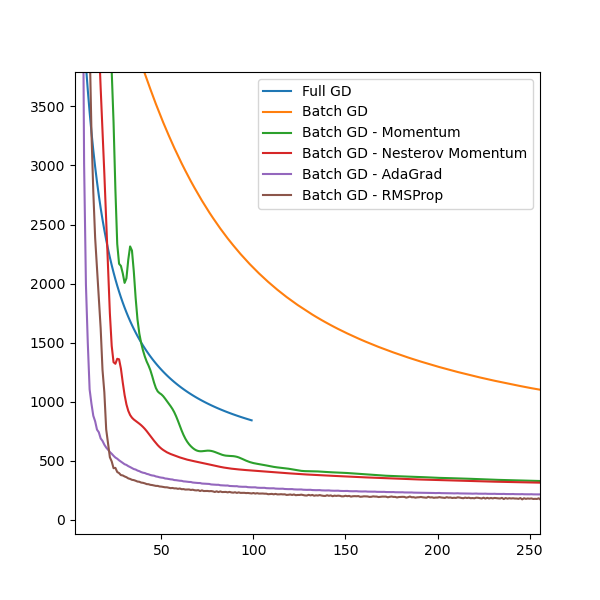

In [80]:
plt.figure(figsize=(6,6))
plt.plot(Ctest_full, label="Full GD")
plt.plot(Ctest_batch, label="Batch GD")
plt.plot(Ctest_batch_m, label="Batch GD - Momentum")
plt.plot(Ctest_batch_nm, label="Batch GD - Nesterov Momentum")
plt.plot(Ctest_batch_Ada, label="Batch GD - AdaGrad")
plt.plot(Ctest_batch_RMS, label="Batch GD - RMSProp")
plt.legend()
plt.show()

As we can see for MNIST DataSet RMSProp reduced the cost with minimum number of steps compared all the other methods
1. RMSProp
2. AdaGrad
3. Nesterov Momentum
4. Momentum
5. Full GD
6. Batch GD